In [2]:
import os
import gzip
import numpy as np
from sklearn.linear_model import *

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
data_dir="/Users/michellehu/git_dirs/ComplexSystems_AMATH563/data/"

## Preprocessing and dataset exploration

In [6]:
# Download data if you haven't already
gz_fns=["t10k-labels-idx1-ubyte.gz", 
        "t10k-images-idx3-ubyte.gz", 
        "train-labels-idx1-ubyte.gz", 
        "train-images-idx3-ubyte.gz"]
data_paths=[data_dir + gz for gz in gz_fns]
data_sources=["http://yann.lecun.com/exdb/mnist/" + gz for gz in gz_fns]
data_sources
for f, source in zip(data_paths, data_sources):
    if os.path.exists(f):
        print("Exists!")
    else:
        print("Missing", f)
        print("Downloading now...")
        !wget -O $f $source

Exists!
Exists!
Exists!
Exists!


In [7]:
# From https://github.com/daniel-e/mnist_octave/blob/master/mnist.py
def loadY(fnlabel):
    f = gzip.open(fnlabel, 'rb')
    f.read(8)
    return np.frombuffer(f.read(), dtype = np.uint8)

def loadX(fnimg):
    f = gzip.open(fnimg, 'rb')
    f.read(16)
    return np.frombuffer(f.read(), dtype = np.uint8).reshape((-1, 28*28))

# Unzip, reformat and reshape
trainX = loadX(data_dir+"train-images-idx3-ubyte.gz")
trainY = loadY(data_dir+"train-labels-idx1-ubyte.gz")
testX = loadX(data_dir+"t10k-images-idx3-ubyte.gz")
testY = loadY(data_dir+"t10k-labels-idx1-ubyte.gz")

In [8]:
# double check that these reshapings make sense
print(trainX[0].shape)
print(trainX[0].reshape(28,28).shape)
print("28*28 =", 28*28)

# Check sizes of train and test datasets and labels
print("train A:", trainX.shape)
print("train B:", trainY.shape)
print("test A:", testX.shape)
print("test B:", testY.shape)

(784,)
(28, 28)
28*28 = 784
train A: (60000, 784)
train B: (60000,)
test A: (10000, 784)
test B: (10000,)


In [9]:
# Look at class distribution
# http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/
print('Digits:  0 1 2 3 4 5 6 7 8 9')
print('labels: %s' % np.unique(trainY))
print('Class distribution: %s' % np.bincount(trainY))

Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


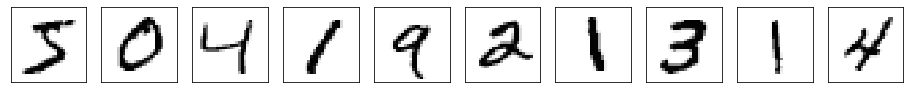

In [10]:
# Check out some digits
plt.figure(figsize=(16,4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = trainX[i].reshape((28,28))
    ax.imshow(img, cmap="Greys")
    ax.set_xticks(())
    ax.set_yticks(())

---

# Set up homework

In [11]:
# A is the vectorized MNIST training images
A=trainX.copy()
print(A.shape)

# B is the set of output vectors
B=trainY.copy()
print(B.shape)

(60000, 784)
(60000,)


### Question 1.

Using various AX=B solvers, determine a mapping from the image space (A) to the label space (B)

In [12]:
%%time

# Instantiate logistic regression models

# with elasticnet regularization and saga solver
saga=LogisticRegression(solver="saga", C=1, n_jobs=4, tol=0.01)
saga_elastic_L1=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=1, n_jobs=4, tol=0.01)
saga_elastic_L2=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=0, n_jobs=4, tol=0.01)
saga_elastic_mix=LogisticRegression(solver="saga",  C=0.01, penalty="elasticnet", l1_ratio=0.8, n_jobs=4, tol=0.01)

# with stochastic gradient descent
sgd_elastic_L1=LogisticRegression(solver="sag", C=0.01, penalty="l1", n_jobs=4, tol=0.01)
sgd_elastic_L2=LogisticRegression(solver="sag", C=0.01, penalty="l2", n_jobs=4, tol=0.01)


solvers = [saga,
           saga_elastic_L1, 
           saga_elastic_L2,
           saga_elastic_mix,
           sgd_elastic_L1,
           sgd_elastic_L2
          ]

sparse_only = [ saga_elastic_L1, 
               saga_elastic_mix,
               sgd_elastic_L1,
          ]

CPU times: user 29 µs, sys: 1 µs, total: 30 µs
Wall time: 31.9 µs


In [ ]:
def optimize(model, x_train, y_train, x_test, y_test, cv=None):
    '''
    model = model instance to use with specified solver, regularization etc.
    x = samples, features; these are observations (images) with # samples = # measurements and features being the attributes of that measurement
    y = samples; these are the _labels_ for the observations of same size as samples
    '''
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    score=model.score(x_test, y_test)
    
    if cv is not None:
        from sklearn.model_selection import cross_val_score
        # Run cv number of simulations using k-fold cross validation approach
        cv_scores=cross_val_score(model, x_train, y_train, cv=cv)
        return (model, predictions, score, cv_scores)    
    else:
        return (model, predictions, score)

In [ ]:
%%time
model=saga_elastic_L1
trained_model, pred, acc = optimize(model, A, B, testX, testY)
print("model trained")

In [ ]:
%%time
saga_elastic_L1_01=LogisticRegression(solver="saga", penalty="elasticnet", l1_ratio=1, n_jobs=4, tol=0.01)
model=saga_elastic_L1_01

trained_model_01, pred_01, acc_01 = optimize(model, A, B, testX, testY)

print("model trained")


In [ ]:
coef=trained_model.coef_
coef=coef.reshape(10,28,28)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(coef[i], vmin=-0.01, vmax=0.006)
    ax.set_title(i)
    
cb_ax=fig.add_axes([0.92, 0.1, 0.03, 0.8])
cbar=fig.colorbar(im, cax=cb_ax)

### with no regularization C=1

In [ ]:
coef=trained_model_01.coef_
coef=coef.reshape(10,28,28)
cmin=coef.min()
cmax=coef.max()

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    im = ax.imshow(coef[i], vmin=cmin, vmax=cmax, cmap="RdBu")
    ax.set_title(i)
    
cb_ax=fig.add_axes([0.92, 0.1, 0.03, 0.8])
cbar=fig.colorbar(im, cax=cb_ax)

### With strong regularization C=0.01

In [ ]:
# Compute losses
def compute_loss(model, predictions, testX, testY):
    report=metrics.classification_report(testY, predictions)
    matrix=metrics.confusion_matrix(testY, predictions, normalize='true')
    return (report, matrix)

In [ ]:
%%time
r, m = compute_loss(trained_model, pred, testX, testY)
r_01, m_01 = compute_loss(trained_model_01, pred_01, testX, testY)

In [ ]:
plt.figure(1)
sns.heatmap(m, annot=True, fmt=".0f", 
#             linewidths=.5, 
            square = True, 
            robust = True,
            cmap = 'Blues_r');

plt.figure(2)
sns.heatmap(m_01, annot=True, fmt=".0f", 
#             linewidths=.5, 
            square = True, 
            robust = True,
            cmap = 'Blues_r');

In [ ]:
print(trained_model.n_iter_)
print(trained_model_01.n_iter_)

Test cross-validation

In [ ]:
%%time
def optimize(model, x_train, y_train, x_test, y_test):
    '''
    model = model instance to use with specified solver, regularization etc.
    x = samples, features; these are observations (images) with # samples = # measurements and features being the attributes of that measurement
    y = samples; these are the _labels_ for the observations of same size as samples
    '''
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    score=model.score(x_test, y_test)
    
    from sklearn.model_selection import cross_val_score
    # 5 simulations using k-fold cross validation approach
    cv_scores=cross_val_score(model, x_train, y_train, cv=5)
    return (model, predictions, score, cv_scores)    

model=saga_elastic_L1_01
trained_model_01, pred_01, acc_01, cv_01 = optimize(model, A, B, testX, testY)

print("model trained and cross-validated")

In [ ]:
# Average of cross-validated scores
print("{0:.3}".format(np.mean(cv_01)))

In [ ]:
# %%time

# # Train, test and assess accuracy of models
# trained_models=[]
# preds=[]
# accs=[]
# cvs=[]

# for model in solvers:
#     trained_model, pred, acc, _ = optimize(model, A, B, testX, testY)
#     trained_models.append(trained_model)
#     preds.append(pred)
#     accs.append(acc)
#     cvs.append(cv)
#     break
# print("models trained")

In [ ]:
# Compare bulk accuracies for one simulation
solver_names = [
           "saga_elastic_L1", 
           "saga_elastic_L2",
           "saga_elastic_mix",
           "sgd_elastic_L1",
           "sgd_elastic_L2"
          ]

bar_positions=range(len(solver_names))
plt.bar(x=bar_positions, height=accs)



In [ ]:
# Use seaborn to plot confusion matrix 
confusion = metrics.confusion_matrix(testY, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(confusion, annot=True, fmt=".0f", 
#             linewidths=.5, 
            square = True, 
            robust = True,
            cmap = 'Blues_r');

plt.ylabel('True label');
plt.xlabel('Predicted label');

# title = str('Accuracy Score: '+ "{0:.3f}".format(score))
# plt.title(title, size = 15);

### Question 2

Promote sparsity and rank which pixels are most informative for digit labelling

Use L1  
rank the 784 pixels to see which is most informative  
Most informative = largest coefficients in matrix X (trained_model.coef_) --> top 5% of pixels, visualized

### Question 3
Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible.

In [ ]:
What does this mean?

### Question 4
Redo the analysis with each digit individually to find the most important pixels for each digit.

### Question 5
Think about the interpretation of what you are doing with this AX = B problem.


In [ ]:
f(x) = something
A = trainX (observations)
B = trainY (labels)

X = beta = loadings so we can transform (i.e. map) A (e.g. data, observations, images) into B (e.g. labels)

Determine X using logistic regression specifying solvers, regularization (constraints)
Use L1 norm where we minimize the average error (better performance with outliers than L2 norm)

Ranking most informative pixels